In [1]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [2]:
# loading image data...
def data_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        #print(path)
        image = cv2.imread(path, 0)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (sx,sy))
        #image = Image.fromarray(image)
        #image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [3]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

image_dataset = data_loader(img_folder,size_x,size_y) # real images...
mask_dataset = data_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
image_dataset = np.expand_dims(image_dataset, axis = 3) # per creare la giusta struttura
mask_dataset = np.array(mask_dataset)

#Espando la dimensione anche della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)
print(mask_dataset_encoded.shape)

#Normalize images (pixel diventano tra 0 e 1)
image_dataset = image_dataset /255. 

(1688, 128, 128, 1)


In [4]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
     

In [5]:
#Le maschere devono avere il formato dell'ultimo layer del modello (128x128x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [6]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "UNet6_25_epochs.hdf5")
model = load_model(path) #tf.keras.models.load_model
model.summary()
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
y_pred=model.predict(X_test)
y_pred.shape #5 canali (correttamente)
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3) 
y_pred_argmax.shape

11/11 [==============================] - 50s 4s/step


(338, 128, 128)

In [32]:

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#si può calcolare la mean IoU per ogni classe
# target_class_ids indicates the class/classes you want to calculate IoU on
for i in range(5):
    loss = tf.keras.metrics.IoU(num_classes=5, target_class_ids=[i])
    loss.update_state(y_test, y_pred_argmax)
    print("Risultato per la classe: ", i ,": ",loss.result().numpy())

Mean IoU = 0.79592365
Risultato per la classe:  0 :  0.9744598
Risultato per la classe:  1 :  0.90411186
Risultato per la classe:  2 :  0.89010394
Risultato per la classe:  3 :  0.41004077
Risultato per la classe:  4 :  0.8009021


1/1 [==============================] - 0s 305ms/step


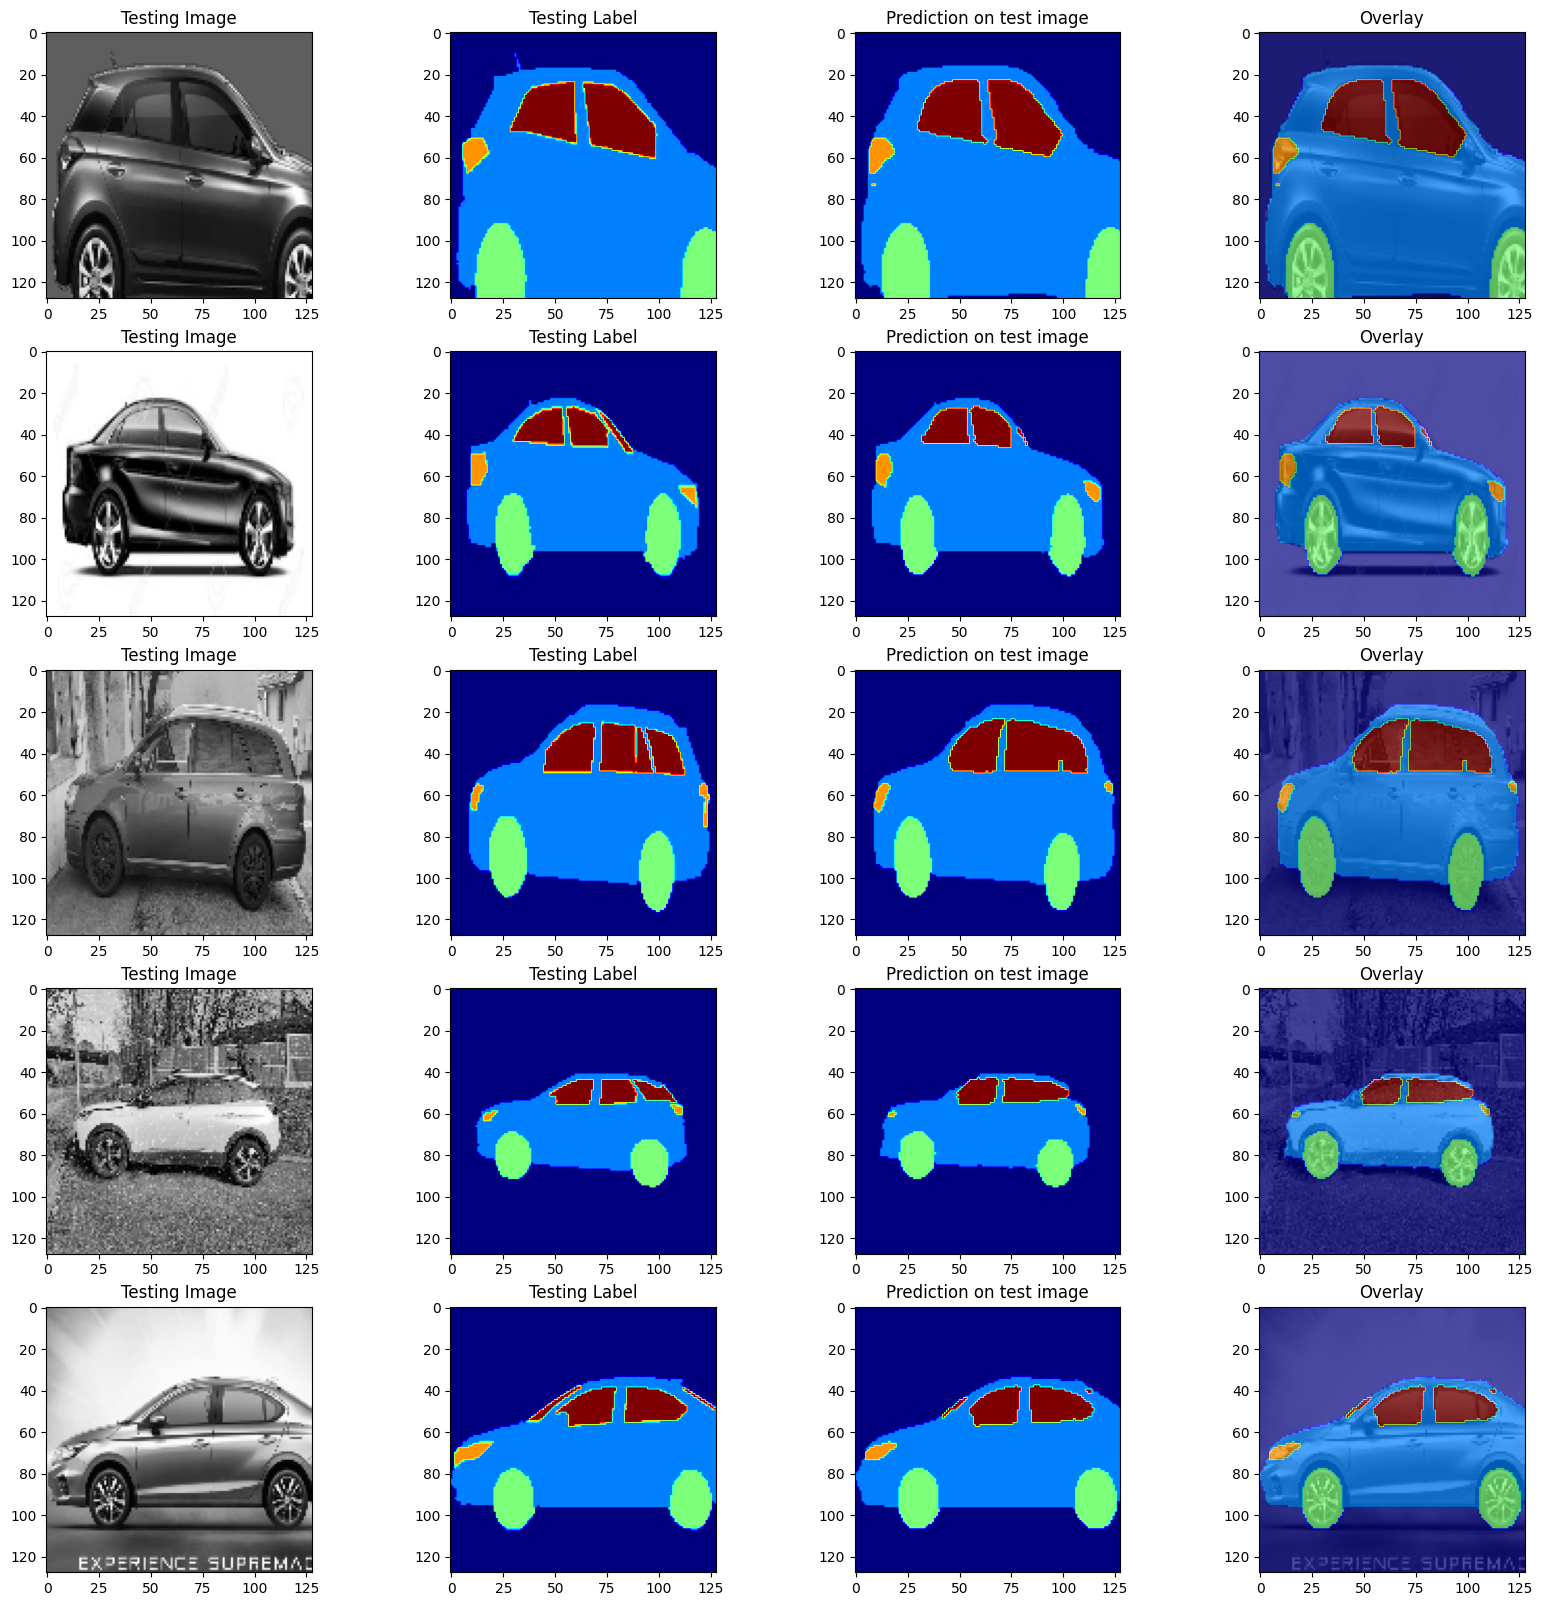

In [25]:
import random

fig = plt.figure(figsize=(20, 20))
for i in range(5):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    ax = fig.add_subplot(5,4,i*4+1)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    
    ax = fig.add_subplot(5,4,i*4+2)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+3)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+4)
    plt.title('Overlay')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.imshow(predicted_img, cmap='jet', alpha=0.7)
    #plt.show()